# Quantifying similarities between fMRI processing pipelines for efficient multiverse analysis

This script contains the implementation of, and supplementary materials for, the "Quantifying similarities between fMRI processing pipelines for efficient multiverse analysis" Guardians Conference Paper.

In short, it applies a graph convolutional neural network combined with the deep graph infomax algorithm to create embeddings for the network of data preprocesing pipelines derived by [Kristanto et al. 2024](https://www.biorxiv.org/content/biorxiv/early/2024/01/15/2024.01.14.575565.full.pdf). The results are then compared with traditional (dis)similarity measures.

The DGI implementation is based on: https://stellargraph.readthedocs.io/en/stable/demos/embeddings/deep-graph-infomax-embeddings.html

In [1]:
import os
import fastdtw
import Levenshtein

import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import tensorflow as tf

from matplotlib import pyplot as plt
from stellargraph import StellarGraph, StellarDiGraph, random as sg_random
from stellargraph.mapper import FullBatchNodeGenerator, CorruptedGenerator
from stellargraph.layer import GCN, DeepGraphInfomax
from stellargraph.utils import plot_history
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler

from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import check_random_state as sklearn_random_state
from sklearn.metrics import pairwise_distances, adjusted_rand_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder

from scipy.stats import zscore
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, leaves_list

wd = os.getcwd()

# Set seeds
seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)
sg_random.set_seed(seed)
sklearn_random_state(seed)

2024-11-12 14:22:17.676278: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-12 14:22:17.680251: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 14:22:17.714173: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 14:22:17.715553: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-12 14:22:18.404343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

RandomState(MT19937) at 0x70606CFE1640

Function to create the graph from nodes and links in csv files:

Nodes
- Are distinct data (pre-)processing steps, 
- Have a name and a group

Links
- Are the number of papers that used a specific pair of steps in succession
- Have a source, target, and weight

In [2]:
def create_graph(directed=True, features=None):
    # Load data
    nodes_df = pd.read_csv(f'{wd}/Data/nodes_clean.csv')
    links_df = pd.read_csv(f'{wd}/Data/links.csv')
    links_df = links_df[links_df['value'] > 1]

    # Create graph
    G_nx = nx.DiGraph() if directed else nx.Graph()

    for index, row in nodes_df.iterrows():
        G_nx.add_node(row['Names'], group=row['Groups'], size=row['size'])
    for index, row in links_df.iterrows():
        G_nx.add_edge(row['source'], row['target'], weight=row['value'])

    # Only keep nodes with at least one connection
    nodes_with_connections = list(set(links_df['source']).union(set(links_df['target'])))
    G_nx = G_nx.subgraph(nodes_with_connections).copy()

    # Node features
    node_features = pd.DataFrame(index=G_nx.nodes())

    if features is None:
        node_features = pd.DataFrame(np.ones((len(G_nx.nodes()), 1)), index=G_nx.nodes())
    else:
        if "frequency" in features:
            node_features["frequency"] = nodes_df.set_index('Names').reindex(G_nx.nodes())["size"]
        if "groups" in features:
            node_features["groups"] = nodes_df.set_index('Names').reindex(G_nx.nodes())["Groups.type"]
        if "degree" in features:
            node_features["degree"] = pd.Series(dict(G_nx.degree())).reindex(G_nx.nodes())
        if "betweenness" in features:
            node_features["betweenness"] = pd.Series(nx.betweenness_centrality(G_nx)).reindex(G_nx.nodes())
        if directed:
            if "indegree" in features:
                node_features["indegree"] = pd.Series(dict(G_nx.in_degree())).reindex(G_nx.nodes())
            if "outdegree" in features:
                node_features["outdegree"] = pd.Series(dict(G_nx.out_degree())).reindex(G_nx.nodes())

        # New features
        if "id" in features:
            node_features['node_id'] = pd.Series({node: i+1 for i, node in enumerate(G_nx.nodes())})
        if "id_onehot" in features:
            id_encoder = OneHotEncoder(sparse=False)
            id_onehot = id_encoder.fit_transform(np.arange(len(G_nx.nodes())).reshape(-1, 1))
            id_onehot_df = pd.DataFrame(id_onehot, index=node_features.index, columns=[f'id_{int(i)}' for i in range(id_onehot.shape[1])])
            node_features = pd.concat([node_features, id_onehot_df], axis=1)

        if "groups_onehot" in features:
            groups_encoder = OneHotEncoder(sparse=False)
            groups_onehot = groups_encoder.fit_transform(nodes_df.set_index('Names').reindex(G_nx.nodes())["Groups.type"].values.reshape(-1, 1))
            groups_onehot_df = pd.DataFrame(groups_onehot, index=node_features.index, columns=[f'group_{int(i)}' for i in range(groups_onehot.shape[1])])
            node_features = pd.concat([node_features, groups_onehot_df], axis=1)

    # Ensure all features are numeric
    node_features = node_features.apply(pd.to_numeric, errors='coerce').fillna(0)

    # Normalize features
    scaler = StandardScaler()
    normalized_features = scaler.fit_transform(node_features)

    # Convert to DataFrame
    normalized_features_df = pd.DataFrame(normalized_features, index=node_features.index, columns=node_features.columns)

    # Convert to StellarGraph object
    G_stellar = StellarDiGraph.from_networkx(G_nx, node_features=normalized_features_df, edge_weight_attr="weight") if directed else StellarGraph.from_networkx(G_nx, node_features=normalized_features_df, edge_weight_attr="weight")

    return G_stellar, G_nx, list(G_stellar.nodes()), node_features


Function for an adaptive learning rate:

In [3]:
def lr_schedule(epoch, lr):
    # Decrease learning rate by 10% every 10 epochs
    if epoch % 10 == 0 and epoch:
        return lr * 0.9
    return lr

Function to apply deep graph infomax with a graph convolutional network to derive the embeddings for the individual nodes:

In [4]:
def run_deep_graph_infomax(G, layer_sizes=None, activations=None, epochs=None, learning_rate=None, pat = None, history_plot=False):
    # Create a full batch generator
    fullbatch_generator = FullBatchNodeGenerator(G, sparse=False)

    # Define the GCN model
    gcn_model = GCN(layer_sizes=layer_sizes, activations=activations, generator=fullbatch_generator)

    # Create a corrupted generator for DeepGraphInfomax
    corrupted_generator = CorruptedGenerator(fullbatch_generator)
    gen = corrupted_generator.flow(G.nodes())

    # Create a DeepGraphInfomax model
    infomax = DeepGraphInfomax(gcn_model, corrupted_generator)
    x_in, x_out = infomax.in_out_tensors()

    model = Model(inputs=x_in, outputs=x_out)
    model.compile(loss=tf.nn.sigmoid_cross_entropy_with_logits, optimizer=Adam(learning_rate=learning_rate))

    # Train the model
    es = EarlyStopping(monitor="loss", min_delta=0, patience=pat)
    lr_scheduler = LearningRateScheduler(lr_schedule)
    history = model.fit(gen, epochs=epochs, verbose=0, callbacks=[es, lr_scheduler])

    if history_plot:
        plot_history(history)
        print(f"Final loss: {history.history['loss'][-1]}")

    # Create an embedding model
    x_emb_in, x_emb_out = gcn_model.in_out_tensors()
    x_out = tf.squeeze(x_emb_out, axis=0)
    emb_model = Model(inputs=x_emb_in, outputs=x_out)

    # Predict embeddings for all nodes
    embeddings = emb_model.predict(fullbatch_generator.flow(G.nodes())[0][0])
    return embeddings

Function to visualize embeddings in 2D throug MDS or TSNE:

In [5]:
def plot_embeddings(G, embeddings, type="MDS"):
    trans = MDS(n_components=2) if type == "MDS" else TSNE(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(embeddings), index=G.nodes())

    fig, ax = plt.subplots(1,2, figsize=(12, 5))
    ax[0].hist(embeddings.flatten(), bins=64) # Histogram of embeddings
    ax[1].scatter(emb_transformed[0], emb_transformed[1], alpha=0.7) # MDS/TSNE plot

    # Annotate nodes
    for i, node in enumerate(emb_transformed.index):
        ax[1].annotate(node, (emb_transformed.iloc[i, 0], emb_transformed.iloc[i, 1]), fontsize=8)
    ax[1].set(xlabel="X1", ylabel="X2")

    plt.suptitle("Embeddings")
    plt.show()

## Main section of the code

We first create the graph and calculate the embeddings:

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Using GCN (local pooling) filters...
Final loss: 0.003074880689382553
1/1 [==============================] - 0s 57ms/step
Embeddings have shape: (47, 32)


/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/manifold/_mds.py:298: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


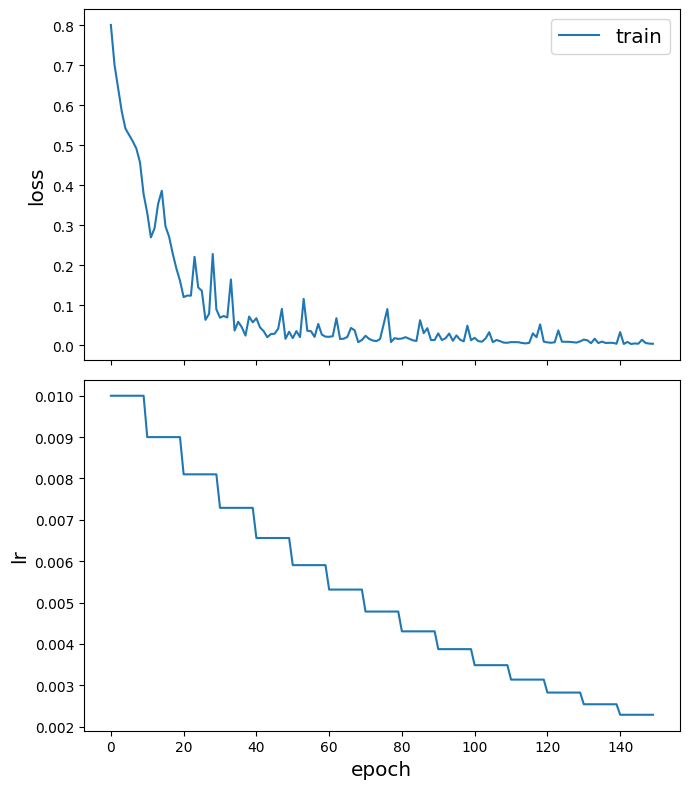

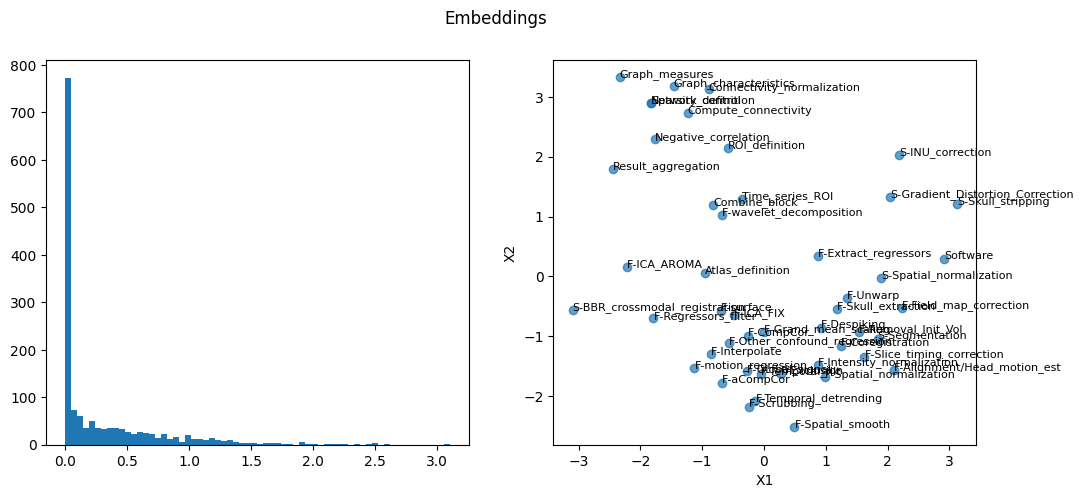

In [6]:
features = ["frequency", "indegree", "outdegree", "id_onehot", "groups_onehot"] # "betweenness" (betweenness not used due to concerns with validity)
G, G_nx, nodes, node_features = create_graph(directed=True, features=features)
embeddings = run_deep_graph_infomax(G, layer_sizes=[32], activations=["relu"], epochs=150, learning_rate=1e-2, pat=80, history_plot=True)

print("Embeddings have shape:", embeddings.shape)
plot_embeddings(G, embeddings, type="MDS") # MDS or TSNE

### Trained model embeddings

We can have a closer look at the embeddings from the trained model. The simplest approach is looking at their mean:

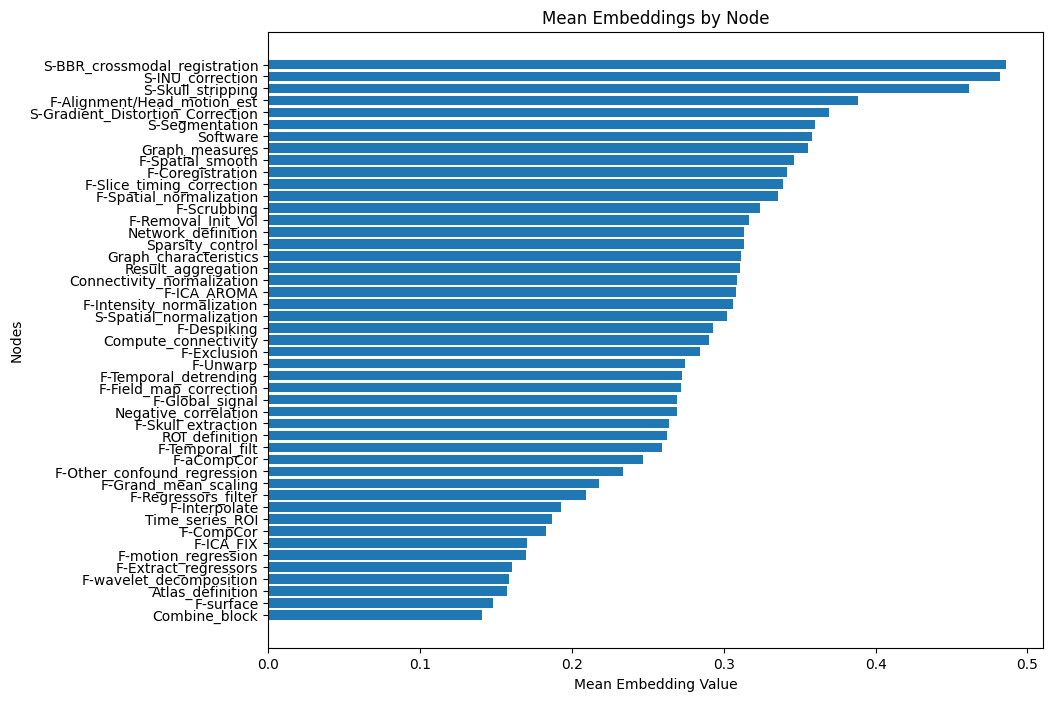

In [7]:
mean_embeddings = np.mean(embeddings, axis=1)

sorted_indices = np.argsort(mean_embeddings)[::-1]
sorted_mean_embeddings = mean_embeddings[sorted_indices]
sorted_nodes = [nodes[i] for i in sorted_indices]

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(sorted_nodes, sorted_mean_embeddings)
plt.xlabel("Mean Embedding Value")
plt.ylabel("Nodes")
plt.title("Mean Embeddings by Node")
plt.gca().invert_yaxis()
plt.show()

We can correlate node embeddings with graph features.

Again, there are several options:
- Mean embedding of each node
- PCA with 1 component
- ...

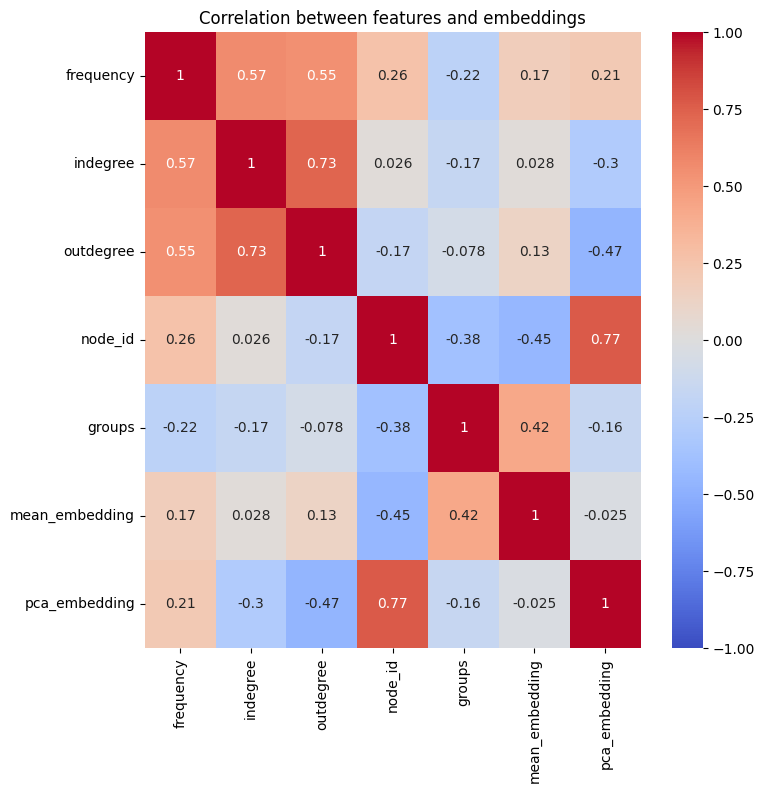

Correlation between PCA and mean: -0.025323900842018448


In [8]:
mean_embeddings = np.mean(embeddings, axis=1)

pca = PCA(n_components=1)
pca_embedings = pca.fit_transform(embeddings).flatten()

nodes_df = pd.read_csv(f'{wd}/Data/nodes_clean.csv')

node_features['node_id'] = pd.Series({node: i+1 for i, node in enumerate(G_nx.nodes())})
node_features["groups"] = nodes_df.set_index('Names').reindex(G_nx.nodes())["Groups.type"]

node_features['mean_embedding'] = pd.Series(mean_embeddings, index=G_nx.nodes())
node_features['pca_embedding'] = pd.Series(pca_embedings, index=G_nx.nodes())

correlation_matrix = node_features.loc[:, ~node_features.columns.str.startswith('group_') & ~node_features.columns.str.startswith('id_')].corr()

# Plot the correlation matrix
plt.figure(figsize=(8, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation between features and embeddings')
plt.show()

print("Correlation between PCA and mean:", np.corrcoef(mean_embeddings, pca_embedings)[0,1])

Alternatively, we can also look at the individual node features. We can see that different neurons learn different features from the data (the pattern is different for each feature):

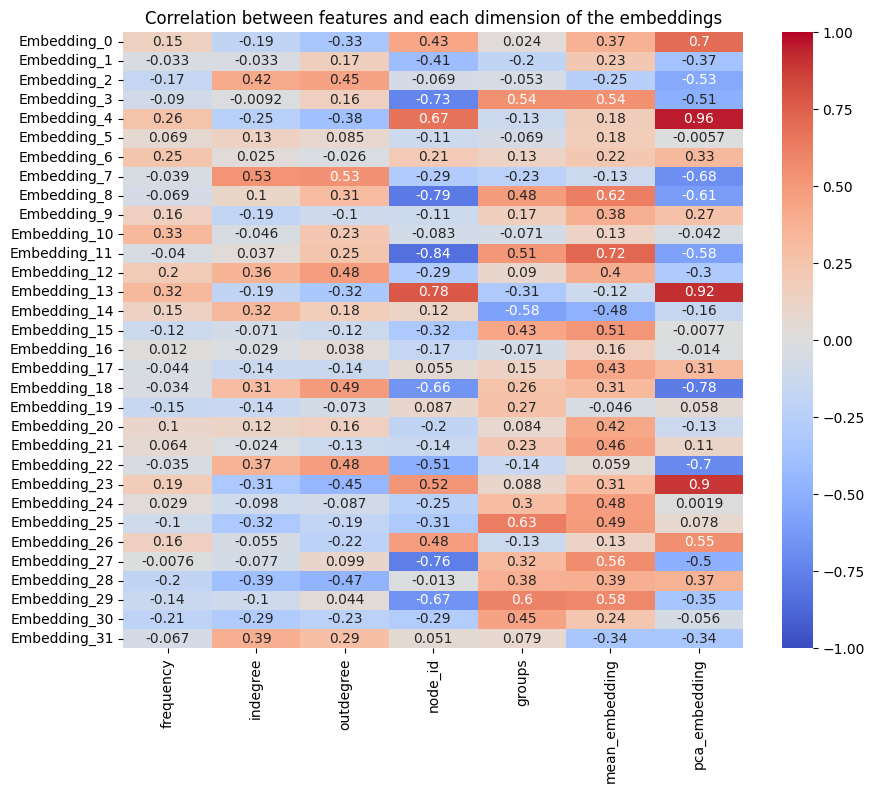

In [9]:
embedding_df = pd.DataFrame(embeddings, index=nodes, columns=[f'Embedding_{i}' for i in range(embeddings.shape[1])])

# Select the relevant columns from node_features
relevant_columns = [col for col in node_features.columns if not col.startswith('group_') and not col.startswith('id_')]
relevant_node_features = node_features[relevant_columns]

# Concatenate the embedding dataframe and the relevant node features
correlation_matrix = pd.concat([embedding_df, relevant_node_features], axis=1).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix.iloc[:32, 32:], annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1)
plt.title('Correlation between features and each dimension of the embeddings')
plt.show()

### Pipelines

We then go from individual nodes to pipelines. As a start, we can calculate a joint embedding for each pipeline. This can be done in various ways as pipelines have varying lenghts.

Options:
- Averaging over nodes (same length joint embedding for each pipeline) -> This is done here
- Summing over nodes (also same length joint embeddings)
- Averaging over features (different length joint embeddings)
- ...


In [10]:
wd = os.getcwd()
pipeline_df = pd.read_excel(f'{wd}/Data/Database_clean.xlsx')
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
authors = [pipeline[0] for pipeline in pipelines]
pipelines = [pipeline[1:] for pipeline in pipelines]

# Create a dictionary to map node labels to their embeddings
embedding_dict = {label: emb for label, emb in zip(nodes, embeddings)}

# Aggregate embeddings for each pipeline -> average over all nodes in the pipelines to get a single feature vector
pipeline_embeddings = []
for pipeline in pipelines:
    pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
    joint_embedding = np.mean(pipeline_embs, axis=0)  # or np.sum(pipeline_embs, axis=0)
    pipeline_embeddings.append(np.mean(pipeline_embs, axis=0))

joint_embeddings = pd.DataFrame(pipeline_embeddings, index=authors)
joint_embeddings.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
"(S. Gao et al., 2021)",0.241311,0.336715,0.485419,0.336644,0.438691,0.230640,0.056673,0.466842,0.592389,0.155416,...,0.355917,0.565797,0.251909,0.270398,0.128762,0.722586,0.212843,0.518950,0.150873,0.196669
"(Fujimoto et al., 2020)",0.336252,0.346435,0.460671,0.308373,0.673647,0.250164,0.115095,0.474598,0.593544,0.158198,...,0.307164,0.756325,0.232970,0.285832,0.150775,0.674208,0.215369,0.473660,0.121587,0.151729
"(Kobayashi et al., 2020)",0.365815,0.338689,0.562470,0.193463,0.791860,0.275978,0.155217,0.578244,0.407859,0.106664,...,0.432675,0.662226,0.162461,0.152988,0.169036,0.418109,0.110986,0.263069,0.047439,0.194630
"(Fukushima et al., 2017)",0.319110,0.327960,0.512871,0.262895,0.702228,0.311136,0.088455,0.458630,0.507906,0.142703,...,0.371091,0.734847,0.225606,0.234924,0.169449,0.549233,0.197943,0.463397,0.111023,0.192638
"(Gracia-Tabuenca et al., 2021)",0.308309,0.357060,0.543195,0.252558,0.749595,0.256696,0.100157,0.539282,0.445705,0.099042,...,0.441109,0.658902,0.154574,0.163099,0.199804,0.442442,0.150237,0.366177,0.086400,0.211442


We can also use dynamic time warping (DTW) instead of averaging:

In [11]:
def dtw_reduce(data):
    num_features, _ = data.shape
    reference_sequence = np.mean(data, axis=0)  # Use mean sequence as reference
    dtw_distances = np.zeros(num_features)

    for i in range(num_features):
        distance, _ = fastdtw.fastdtw(data[i], reference_sequence)
        dtw_distances[i] = distance

    return dtw_distances

# Joint embeddings with dynamic time warping
pipeline_embeddings_dtw = []
for pipeline in pipelines:
        pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

# Convert the result to a DataFrame for inspection
joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw, index=authors)
joint_embeddings_dtw.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
"(S. Gao et al., 2021)",3.905970,7.082886,11.042709,4.220237,12.317825,4.082058,5.071946,9.716071,10.879835,3.027989,...,7.260807,12.694191,4.164262,5.429213,5.044317,13.288761,4.396573,8.669680,5.284683,5.600060
"(Fujimoto et al., 2020)",6.028800,7.266280,12.233022,5.154384,18.213192,3.959693,4.375418,11.257806,11.669735,3.463268,...,8.425131,17.796789,4.149874,5.626569,5.264749,14.266505,4.238236,9.690132,6.247877,6.499539
"(Kobayashi et al., 2020)",6.179661,5.399128,11.232591,4.463897,19.149134,4.202203,4.607587,11.580154,9.082012,3.333540,...,8.041701,16.297191,3.612357,5.139602,3.960854,10.124553,3.993495,5.745527,5.428646,5.405257
"(Fukushima et al., 2017)",7.580456,8.677112,17.372786,6.902713,24.145660,6.378252,7.330191,13.884197,13.799412,4.478879,...,10.050777,22.736894,5.880122,7.513729,6.164300,16.518883,6.208565,11.768919,7.762541,7.132013
"(Gracia-Tabuenca et al., 2021)",4.887661,5.565091,10.504595,4.049554,17.016603,3.996788,4.300095,10.109403,8.269935,3.442372,...,7.388153,15.112031,3.951279,4.345979,3.924264,9.879304,4.396816,5.976093,4.865376,5.364237


Similarity matrices are then calculated for the embeddings (mean and DTW) as well as on the pipelines themselves (jaccard, hamming, levenshtein).

The similarity matrix is calculated as 1 minus the normalized distance matrix

In [12]:
# Mean embeddings: Calculate the dissimilarity matrix and scale to convert it to a similarity matrix
dissimilarity_matrix = squareform(pdist(joint_embeddings, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity = 1 - scaled_dissimilarity_matrix

# Perform hierarchical clustering on the similarity matrix
row_linkage = linkage(embedding_similarity, method='average', metric='euclidean')
col_linkage = linkage(embedding_similarity.T, method='average', metric='euclidean')
row_order = leaves_list(row_linkage)
col_order = leaves_list(col_linkage)

# DTW embeddings
dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
min_val = np.min(dissimilarity_matrix)
max_val = np.max(dissimilarity_matrix)
scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

# Levenshtein distance
n = len(pipelines)
levenshtein_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

min_val = np.min(levenshtein_distance)
max_val = np.max(levenshtein_distance)
scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
levenshtein_similarity = 1 - scaled_levenshtein_distance

# Hamming distance
n = len(pipelines)
hamming_distance = np.zeros((n,n))

for i in range(n):
    for j in range(n):
        if i != j:
            hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

min_val = np.min(hamming_distance)
max_val = np.max(hamming_distance)
scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
hamming_similarity = 1 - scaled_hamming_distance

# Jaccard distance
mlb = MultiLabelBinarizer()
pipeline_binary = mlb.fit_transform(pipelines)
jaccard_similarity = 1 - pairwise_distances(pipeline_binary, metric="jaccard")

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/metrics/pairwise.py:2182: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


Plot the results:

In [13]:
triu_indices = np.triu_indices_from(embedding_similarity, k=1)
upper_triangle_embeddings = embedding_similarity[triu_indices]
upper_triangle_embeddings_dtw = embedding_similarity_dtw[triu_indices]
upper_triangle_hamming = hamming_similarity[triu_indices]
upper_triangle_levenshtein = levenshtein_similarity[triu_indices]
upper_triangle_jaccard = jaccard_similarity[triu_indices]

# Create a DataFrame with the upper triangle similarities
similarity_data = pd.DataFrame({
    'Jaccard': upper_triangle_jaccard,
    'Embedding (mean)': upper_triangle_embeddings,
    'Embedding (DTW)': upper_triangle_embeddings_dtw,
    'Hamming': upper_triangle_hamming,
    'Levenshtein': upper_triangle_levenshtein,

})

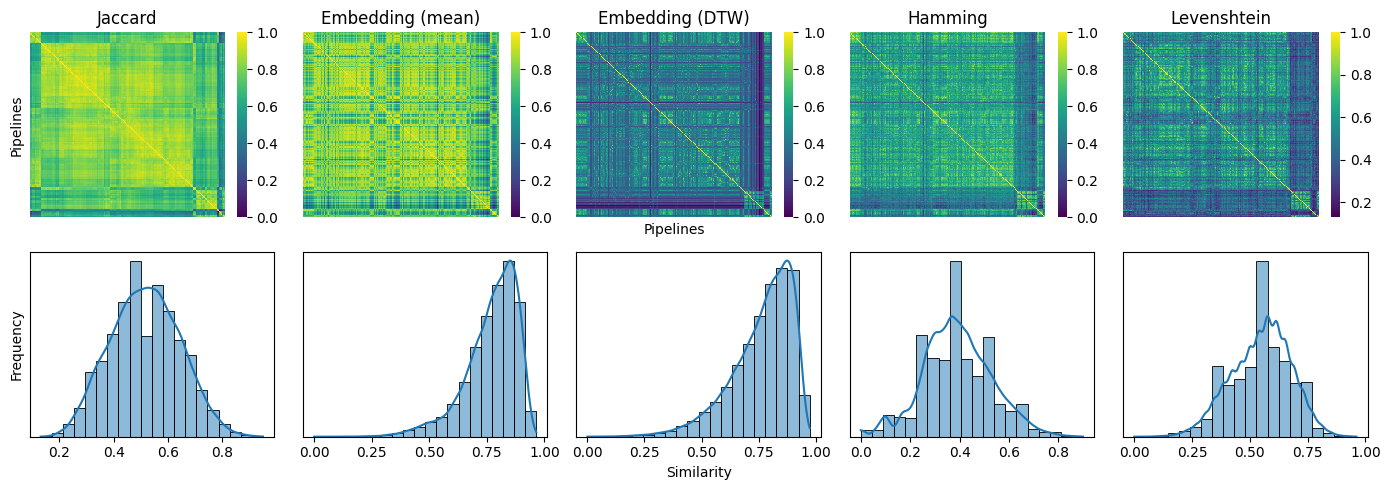

In [14]:
# Plot the similarity matrices
fig, axes = plt.subplots(2, 5, figsize=(14, 5))

sns.heatmap(embedding_similarity[np.ix_(row_order, col_order)], cmap='viridis', ax=axes[0,0])
axes[0,0].set_title('Jaccard')
axes[0,0].set_xticks([])
axes[0,0].set_yticks([])
axes[0,0].set_ylabel('Pipelines')

sns.heatmap(embedding_similarity_dtw[np.ix_(row_order, col_order)], cmap='viridis', ax=axes[0,1])
axes[0,1].set_title('Embedding (mean)')
axes[0,1].set_xticks([])
axes[0,1].set_yticks([])

sns.heatmap(hamming_similarity[np.ix_(row_order, col_order)], cmap='viridis', ax=axes[0,2])
axes[0,2].set_title('Embedding (DTW)')
axes[0,2].set_xticks([])
axes[0,2].set_yticks([])
axes[0,2].set_xlabel('Pipelines')

sns.heatmap(levenshtein_similarity[np.ix_(row_order, col_order)], cmap='viridis', ax=axes[0,3])
axes[0,3].set_title('Hamming')
axes[0,3].set_xticks([])
axes[0,3].set_yticks([])

sns.heatmap(jaccard_similarity[np.ix_(row_order, col_order)], cmap='viridis', ax=axes[0,4])
axes[0,4].set_title('Levenshtein')
axes[0,4].set_xticks([])
axes[0,4].set_yticks([])

sns.histplot(data=similarity_data['Jaccard'], kde=True, bins=20, ax=axes[1,0])
axes[1,0].set_xlabel('')
axes[1,0].set_ylabel('Frequency')
axes[1,0].set_yticks([])

sns.histplot(data=similarity_data['Embedding (mean)'], kde=True, bins=20, ax=axes[1,1])
axes[1,1].set_xlabel('')
axes[1,1].set_ylabel('')
axes[1,1].set_yticks([])

sns.histplot(data=similarity_data['Embedding (DTW)'], kde=True, bins=20, ax=axes[1,2])
axes[1,2].set_xlabel('Similarity')
axes[1,2].set_ylabel('')
axes[1,2].set_yticks([])

sns.histplot(data=similarity_data['Hamming'], kde=True, bins=20, ax=axes[1,3])
axes[1,3].set_xlabel('')
axes[1,3].set_ylabel('')
axes[1,3].set_yticks([])

sns.histplot(data=similarity_data['Levenshtein'], kde=True, bins=20, ax=axes[1,4])
axes[1,4].set_title('')
axes[1,4].set_xlabel('')
axes[1,4].set_ylabel('')
axes[1,4].set_yticks([])

plt.tight_layout()

We then investigate similarity between measures. 

First, the pipleines are clustered based on the similarity matrices. Second, the ARI is calculated to quantify the similarty of the cultering results across matrices.

/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/home/mibur/miniconda3/envs/stellar/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: 

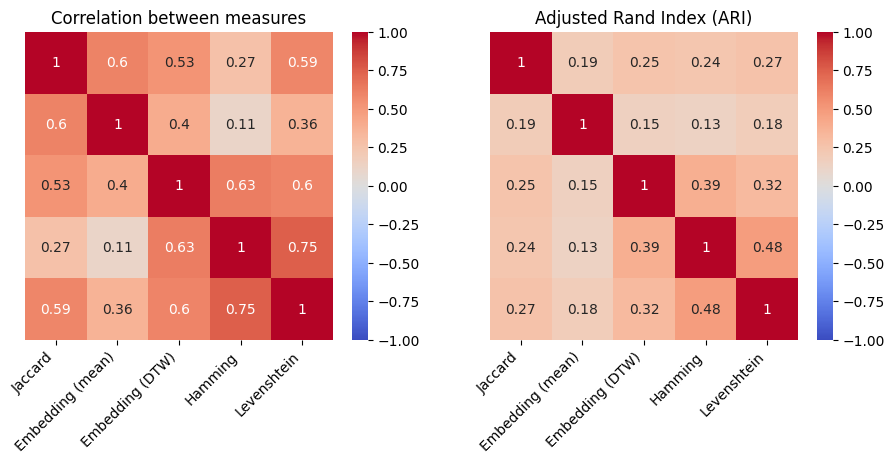

<Figure size 700x600 with 0 Axes>

In [15]:
### Perform clustering with k-means and the elbow method

# Define the similarity matrices
similarity_matrices = [jaccard_similarity, embedding_similarity, embedding_similarity_dtw, hamming_similarity, levenshtein_similarity]
similarity_matrix_names = ['Jaccard', 'Embedding (mean)', 'Embedding (DTW)', 'Hamming', 'Levenshtein']
"""
# Perform k-means clustering with the elbow method for each similarity matrix
for similarity_matrix, similarity_matrix_name in zip(similarity_matrices, similarity_matrix_names):
    wcss = []
    max_clusters = 15

    for k in range(1, max_clusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=0)
        kmeans.fit(similarity_matrix)
        wcss.append(kmeans.inertia_)

    # Plot the elbow curve
    plt.plot(range(1, max_clusters + 1), wcss)
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title(f'Elbow Curve for {similarity_matrix_name}')
    plt.show()"""

### Measuring the ARI index of all clustering results
# Define the number of clusters
num_clusters = 4

# Initialize an empty dataframe to store the cluster results
cluster_results = pd.DataFrame(index=range(1, len(pipelines) + 1))

# Perform k-means clustering and store the assigned groups for each similarity matrix
for i, similarity_matrix_name in enumerate(similarity_matrix_names):
    kmeans = KMeans(n_clusters=num_clusters, random_state=29)
    kmeans.fit(similarity_matrices[i])
    labels = kmeans.labels_

    cluster_results[similarity_matrix_name] = labels

# Display the cluster results dataframe
#print(cluster_results)

# Calculate the Adjusted Rand Index (ARI) for each similarity matrix
ari_matrix = np.zeros((len(similarity_matrices), len(similarity_matrices)))
for i in range(len(similarity_matrices)):
    for j in range(len(similarity_matrices)):
        ari = adjusted_rand_score(cluster_results[similarity_matrix_names[i]], cluster_results[similarity_matrix_names[j]])
        ari_matrix[i, j] = ari

# Convert the ARI matrix to a DataFrame for better visualization
ari_matrix_df = pd.DataFrame(ari_matrix, index=similarity_matrix_names, columns=similarity_matrix_names)

# Count the number of pipelines in each cluster for each similarity matrix
cluster_counts = cluster_results.apply(lambda x: x.value_counts()).T
df = pd.DataFrame(cluster_counts.values, index=similarity_matrix_names, columns=[f'Cluster {i+1}' for i in range(num_clusters)])
df


fig, axes = plt.subplots(1, 2, figsize=(11, 4))

# Calculate the correlation matrix
correlation_matrix = similarity_data.corr()

# Plot the correlation matrix
plt.figure(figsize=(7, 6))

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True, yticklabels=[], ax=axes[0])
axes[0].set_title('Correlation between measures')
axes[0].tick_params(axis='x', rotation=45)
for label in axes[0].get_xticklabels():
    label.set_ha('right')

# Plot the ARI matrix
sns.heatmap(ari_matrix_df, annot=True, cmap='coolwarm', cbar=True, vmin=-1, vmax=1, square=True, yticklabels=[], ax=axes[1])
axes[1].set_title('Adjusted Rand Index (ARI)')
axes[1].tick_params(axis='x', rotation=45)
for label in axes[1].get_xticklabels():
    label.set_ha('right')
plt.show()


We then investigate the differences among GNN-DTW, Hamming, and Levenshtein.
First, computed the differences of pipeline similarity matrices between 2 pairs. Second, find the 10 pairs of pipelines that exhibit largest differences and interpret them

In [16]:
# Z-normalize the similarity matrices
embedding_similarity_dtw_z = zscore(embedding_similarity_dtw)
hamming_similarity_z = zscore(hamming_similarity)
levenshtein_similarity_z = zscore(levenshtein_similarity)

# Calculate dissimilarity matrices
diss_dtw_hamming = np.abs(embedding_similarity_dtw_z - hamming_similarity_z)
diss_dtw_levenshtein = np.abs(embedding_similarity_dtw_z - levenshtein_similarity_z)
diss_hamming_levenshtein = np.abs(hamming_similarity_z - levenshtein_similarity_z)

def find_top_pairs(dissimilarity_matrix):
    n_pipelines = dissimilarity_matrix.shape[0]
    pairs = [(i, j) for i in range(n_pipelines) for j in range(i + 1, n_pipelines)]
    differences = [(dissimilarity_matrix[i, j], (i, j)) for i, j in pairs]
    differences.sort(reverse=True, key=lambda x: x[0])

    top_differences = [diff[0] for diff in differences[:10]]
    top_pairs = [diff[1] for diff in differences[:10]]

    return top_pairs, top_differences

# Find the top pairs for each dissimilarity matrix
top_dtw_hamming_pairs, top_dtw_hamming_diffs = find_top_pairs(diss_dtw_hamming)
top_dtw_levenshtein_pairs, top_dtw_levenshtein_diffs = find_top_pairs(diss_dtw_levenshtein)
top_hamming_levenshtein_pairs, top_hamming_levenshtein_diffs = find_top_pairs(diss_hamming_levenshtein)

# Print the results
def print_top_pairs(top_pairs, top_diffs, title, sim_matrix1, sim_matrix2):
    print(title)
    for idx, (i, j) in enumerate(top_pairs):
        diff = top_diffs[idx]
        print(f"Pair ({i}, {j}) has a dissimilarity of {diff}")
        print(f"Pipeline {i}: {pipelines[i]}")
        print(f"Pipeline {j}: {pipelines[j]}")
        print(f"Similarity by first measure: {sim_matrix1[i, j]}")
        print(f"Similarity by second measure: {sim_matrix2[i, j]}")
        print()

print_top_pairs(top_dtw_hamming_pairs, top_dtw_hamming_diffs, "Top pairs for Embedding Similarity (DTW) vs Hamming Similarity:", embedding_similarity_dtw_z, hamming_similarity_z)
print_top_pairs(top_dtw_levenshtein_pairs, top_dtw_levenshtein_diffs, "Top pairs for Embedding Similarity (DTW) vs Levenshtein Similarity:", embedding_similarity_dtw_z, levenshtein_similarity_z)
print_top_pairs(top_hamming_levenshtein_pairs, top_hamming_levenshtein_diffs, "Top pairs for Hamming Similarity vs Levenshtein Similarity:", hamming_similarity_z, levenshtein_similarity_z)

Top pairs for Embedding Similarity (DTW) vs Hamming Similarity:
Pair (3, 19) has a dissimilarity of 4.74895135941903
Pipeline 3: ['Software', 'S-Gradient_Distortion_Correction', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Correction', 'F-Alignment/Head_motion_est', 'F-Field_map_correction', 'F-Unwarp', 'F-Coregistration', 'F-Spatial_normalization', 'F-Intensity_normalization', 'F-Removal_Init_Vol', 'F-Scrubbing', 'F-Interpolate', 'F-Global_signal', 'F-Other_confound_regression', 'F-motion_regression', 'F-Temporal_filt', 'F-Temporal_detrending', 'F-Exclusion', 'Atlas_definition', 'Time_series_ROI', 'ROI_definition', 'Compute_connectivity', 'Connectivity_normalization', 'Network_definition', 'Graph_characteristics', 'Negative_correlation', 'Sparsity_control', 'Graph_measures']
Pipeline 19: ['Software', 'S-Gradient_Distortion_Correction', 'S-Skull_stripping', 'S-BBR_crossmodal_registration', 'S-INU_correction', 'S-Gradient_Distortion_Co


We further systematically evaluate the differences in length and switching behavior of cleaning/parcellation.

The next block will retrain the network m times and extract the top n top dissimilar pairs of pipelines.

In [17]:
pipeline_df = pd.read_excel(f'{wd}/Data/Database_clean.xlsx')
pipelines = pipeline_df.apply(lambda row: row.dropna().tolist(), axis=1).tolist()
authors = [pipeline[0] for pipeline in pipelines]
pipelines = [pipeline[1:] for pipeline in pipelines]


######################
# PARAMETER DEFINITION
n_top_pairs = 10
n_repetitions = 10

def find_top_pairs(dissimilarity_matrix):
    n_pipelines = dissimilarity_matrix.shape[0]
    pairs = [(i, j) for i in range(n_pipelines) for j in range(i + 1, n_pipelines)]
    differences = [(dissimilarity_matrix[i, j], (i, j)) for i, j in pairs]
    differences.sort(reverse=True, key=lambda x: x[0])

    top_differences = [diff[0] for diff in differences[:n_top_pairs]]
    top_pairs = [diff[1] for diff in differences[:n_top_pairs]]

    return top_pairs, top_differences

# Initialize lists to store the results from each run
all_dtw_hamming_pairs = []
all_dtw_levenshtein_pairs = []
all_hamming_levenshtein_pairs = []

all_dtw_hamming_diff = []
all_dtw_levenshtein_diff = []
all_hamming_levenshtein_diff = []

# Run the a few times for better estimate
for _ in range(n_repetitions):
    embeddings = run_deep_graph_infomax(G, layer_sizes=[32], activations=["relu"], epochs=150, learning_rate=1e-2, pat=80, history_plot=False)
    embedding_dict = {label: emb for label, emb in zip(nodes, embeddings)}

    # DTW
    pipeline_embeddings_dtw = []
    for pipeline in pipelines:
        pipeline_embs = [embedding_dict[node] for node in pipeline if node in embedding_dict]
        if pipeline_embs:
            pipeline_embs = np.array(pipeline_embs)
            pipeline_embs = np.transpose(pipeline_embs)
            joint_embedding = dtw_reduce(pipeline_embs)
            pipeline_embeddings_dtw.append(joint_embedding)

    joint_embeddings_dtw = pd.DataFrame(pipeline_embeddings_dtw, index=authors)
    dissimilarity_matrix = squareform(pdist(joint_embeddings_dtw, metric='euclidean'))
    min_val = np.min(dissimilarity_matrix)
    max_val = np.max(dissimilarity_matrix)
    scaled_dissimilarity_matrix = (dissimilarity_matrix - min_val) / (max_val - min_val)
    embedding_similarity_dtw = 1 - scaled_dissimilarity_matrix

    # Levenshtein
    n = len(pipelines)
    levenshtein_distance = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                levenshtein_distance[i, j] = Levenshtein.distance(pipelines[i], pipelines[j])

    min_val = np.min(levenshtein_distance)
    max_val = np.max(levenshtein_distance)
    scaled_levenshtein_distance = (levenshtein_distance - min_val) / (max_val - min_val)
    levenshtein_similarity = 1 - scaled_levenshtein_distance

    # Hamming
    hamming_distance = np.zeros((n, n))

    for i in range(n):
        for j in range(n):
            if i != j:
                hamming_distance[i, j] = Levenshtein.hamming(pipelines[i], pipelines[j])

    min_val = np.min(hamming_distance)
    max_val = np.max(hamming_distance)
    scaled_hamming_distance = (hamming_distance - min_val) / (max_val - min_val)
    hamming_similarity = 1 - scaled_hamming_distance

    embedding_similarity_dtw_z = zscore(embedding_similarity_dtw)
    hamming_similarity_z = zscore(hamming_similarity)
    levenshtein_similarity_z = zscore(levenshtein_similarity)

    diff_dtw_hamming = np.abs(embedding_similarity_dtw_z - hamming_similarity_z)
    diff_dtw_levenshtein = np.abs(embedding_similarity_dtw_z - levenshtein_similarity_z)
    diff_hamming_levenshtein = np.abs(hamming_similarity_z - levenshtein_similarity_z)

    top_dtw_hamming_pairs, top_dtw_hamming_diff = find_top_pairs(diff_dtw_hamming)
    top_dtw_levenshtein_pairs, top_dtw_levenshtein_diff = find_top_pairs(diff_dtw_levenshtein)
    top_hamming_levenshtein_pairs, top_hamming_levenshtein_diff = find_top_pairs(diff_hamming_levenshtein)

    # Accumulate the pairs
    all_dtw_hamming_pairs.extend(top_dtw_hamming_pairs)
    all_dtw_levenshtein_pairs.extend(top_dtw_levenshtein_pairs)
    all_hamming_levenshtein_pairs.extend(top_hamming_levenshtein_pairs)

    # Accumulate the differences
    all_dtw_hamming_diff.extend(top_dtw_hamming_diff)
    all_dtw_levenshtein_diff.extend(top_dtw_levenshtein_diff)
    all_hamming_levenshtein_diff.extend(top_hamming_levenshtein_diff)

Using GCN (local pooling) filters...
1/1 [==============================] - 0s 29ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 34ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 31ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 32ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 44ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 44ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 38ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 34ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 34ms/step
Using GCN (local pooling) filters...
1/1 [==============================] - 0s 33ms/step


In [18]:
def calculate_length(pipelines, pairs, sim_mat1, sim_mat2):
    length_differences = []
    measure1_more_similar_count = 0

    for (idx1, idx2) in pairs:
        # Pipeline length difference
        p1_length = len(pipelines[idx1])
        p2_length = len(pipelines[idx2])
        length_differences.append(abs(p1_length - p2_length))

        # Direction of similarity judgment
        if sim_mat1[idx1, idx2] > sim_mat2[idx1, idx2]:
            measure1_more_similar_count += 1

    return length_differences, measure1_more_similar_count

# Calculate the average length differences, direction counts, and similarity judgments
length_diff_dtw_hamming, measure1_more_similar_count_dtw_hamming = calculate_length(pipelines, all_dtw_hamming_pairs, embedding_similarity_dtw_z, hamming_similarity_z)
length_diff_dtw_levenshtein, measure1_more_similar_count_dtw_levenshtein = calculate_length(pipelines, all_dtw_levenshtein_pairs, embedding_similarity_dtw_z, levenshtein_similarity_z)
length_diff_hamming_levenshtein, measure1_more_similar_count_hamming_levenshtein = calculate_length(pipelines, all_hamming_levenshtein_pairs, hamming_similarity_z, levenshtein_similarity_z)

# Print the results
print("Mean length difference between pipelines:")
print(f"DTW vs Hamming: {np.mean(length_diff_dtw_hamming)}")
print(f"DTW vs Levenshtein: {np.mean(length_diff_dtw_levenshtein)}")
print(f"Hamming vs Levenshtein: {np.mean(length_diff_hamming_levenshtein)}")

print("\nDirection of similarity judgment:")
print(f"DTW vs Hamming: DTW judges more similar {measure1_more_similar_count_dtw_hamming} of {len(length_diff_dtw_hamming)} times")
print(f"DTW vs Levenshtein: DTW judges more similar {measure1_more_similar_count_dtw_levenshtein} of {len(length_diff_dtw_levenshtein)} times")
print(f"Hamming vs Levenshtein: Hamming judges more similar {measure1_more_similar_count_hamming_levenshtein} of {len(length_diff_hamming_levenshtein)} times")


Mean length difference between pipelines:
DTW vs Hamming: 9.34
DTW vs Levenshtein: 7.13
Hamming vs Levenshtein: 0.2

Direction of similarity judgment:
DTW vs Hamming: DTW judges more similar 0 of 100 times
DTW vs Levenshtein: DTW judges more similar 35 of 100 times
Hamming vs Levenshtein: Hamming judges more similar 90 of 100 times


In [19]:
def calculate_switching(pipelines, pairs, sim_mat1, sim_mat2):
    switch_count = 0
    total_count = 0
    measure1_more_similar_count = 0

    for first_pipeline, second_pipeline in pairs:

        pipeline1 = pipelines[first_pipeline]
        pipeline2 = pipelines[second_pipeline]

        # Get the index of Atlas_definition, if it exists
        idx_parc1 = pipeline1.index("Atlas_definition") if "Atlas_definition" in pipeline1 else None
        idx_parc2 = pipeline2.index("Atlas_definition") if "Atlas_definition" in pipeline2 else None

        # Get the indices of the cleaning steps, if they exist
        idx_c11 = pipeline1.index("F-Temporal_filt") if "F-Temporal_filt" in pipeline1 else None
        idx_c21 = pipeline1.index("F-motion_regression") if "F-motion_regression" in pipeline1 else None
        idx_c31 = pipeline1.index("F-Other_confound_regression") if "F-Other_confound_regression" in pipeline1 else None

        idx_c12 = pipeline2.index("F-Temporal_filt") if "F-Temporal_filt" in pipeline2 else None
        idx_c22 = pipeline2.index("F-motion_regression") if "F-motion_regression" in pipeline2 else None
        idx_c32 = pipeline2.index("F-Other_confound_regression") if "F-Other_confound_regression" in pipeline2 else None

        # Build a list of valid comparison indices for each pipeline
        idx_c1_list = [idx for idx in [idx_c11, idx_c21, idx_c31] if idx is not None]
        idx_c2_list = [idx for idx in [idx_c12, idx_c22, idx_c32] if idx is not None]

        # Check if both pipelines have atlas definitiona and at least one of the cleaning options
        if (idx_parc1 is not None and idx_c1_list) and (idx_parc2 is not None and idx_c2_list):
            total_count += 1

        # Switching conditions indeendent of the order
        if idx_parc1 is not None and idx_c1_list:
            parc1_condition = any(idx_parc1 < idx_c for idx_c in idx_c1_list)
            parc1_opposite_condition = any(idx_parc1 > idx_c for idx_c in idx_c1_list)
        else:
            parc1_condition = parc1_opposite_condition = False

        if idx_parc2 is not None and idx_c2_list:
            parc2_condition = any(idx_parc2 > idx_c for idx_c in idx_c2_list)
            parc2_opposite_condition = any(idx_parc2 < idx_c for idx_c in idx_c2_list)
        else:
            parc2_condition = parc2_opposite_condition = False

        # If both conditions hold for either the original or opposite check, increment the switch count
        if (parc1_condition and parc2_condition) or (parc1_opposite_condition and parc2_opposite_condition):
            switch_count += 1

            if sim_mat1[first_pipeline, second_pipeline] > sim_mat2[first_pipeline, second_pipeline]:
                measure1_more_similar_count += 1

    return switch_count, total_count, measure1_more_similar_count


switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_dtw_hamming_pairs, embedding_similarity_dtw_z, hamming_similarity_z)
print(f"DTW-Hamming switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, DTW judged more similar {measure1_more_similar_count} of {switch_count} times\n")

switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_dtw_levenshtein_pairs, embedding_similarity_dtw_z, levenshtein_similarity_z)
print(f"DTW-Levenshtein switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, DTW judged more similar {measure1_more_similar_count} of {switch_count} times\n")

switch_count, total_count, measure1_more_similar_count = calculate_switching(pipelines, all_hamming_levenshtein_pairs, hamming_similarity_z, levenshtein_similarity_z)
print(f"Hamming-Levenshtein switch clean/parcellation order in {switch_count / total_count * 100}% of comparisons ({switch_count}/{total_count})")
print(f"If a switch is present, Hamming judged more similar {measure1_more_similar_count} of {switch_count} times")

DTW-Hamming switch clean/parcellation order in 18.823529411764707% of comparisons (16/85)
If a switch is present, DTW judged more similar 0 of 16 times

DTW-Levenshtein switch clean/parcellation order in 42.857142857142854% of comparisons (30/70)
If a switch is present, DTW judged more similar 29 of 30 times

Hamming-Levenshtein switch clean/parcellation order in 0.0% of comparisons (0/70)
If a switch is present, Hamming judged more similar 0 of 0 times
